In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

try:
    df = pd.read_csv('../data/raw/training.csv')
    print("Data loaded successfully!")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: training.csv not found in ../data/raw/. Please check the file path.")

df.head()

Data loaded successfully!
Dataset shape: (95662, 16)


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [2]:
# Data types and non-null counts
df.info()

# Summary statistics for numerical columns, min max  of Amount and Value. A positive Amount is a debit, negative is a credit. 
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000


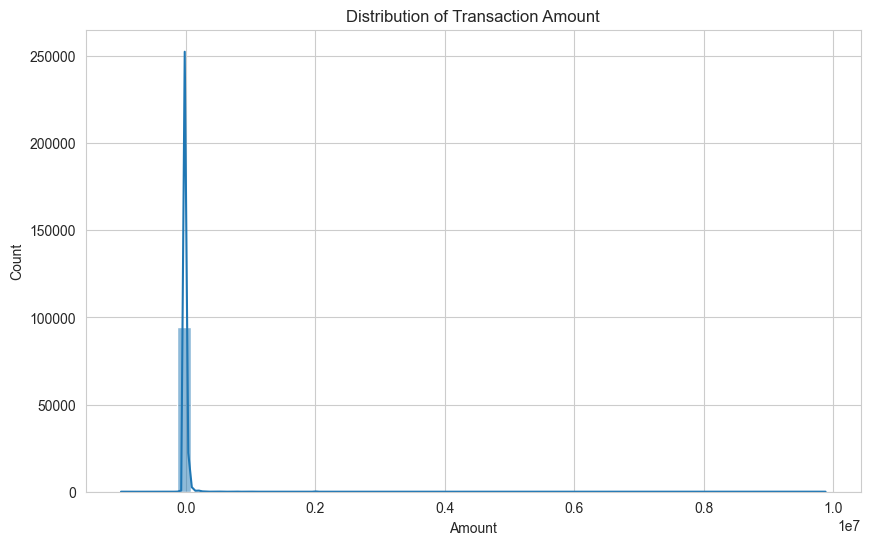

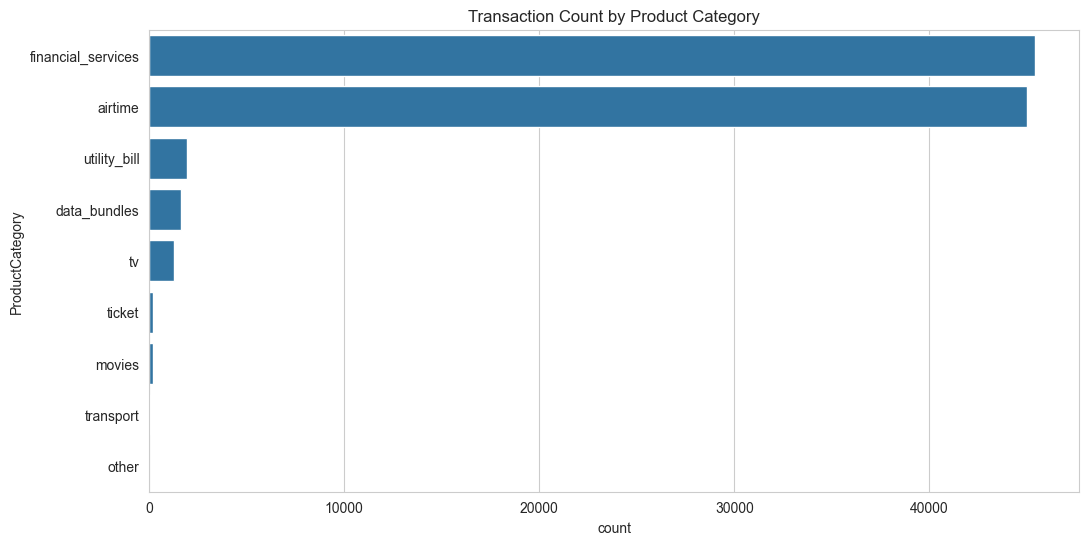

In [3]:
# Distribution of transaction Amount
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amount')
plt.show()

# Distribution of categorical features
plt.figure(figsize=(12, 6))
sns.countplot(y=df['ProductCategory'], order=df['ProductCategory'].value_counts().index)
plt.title('Transaction Count by Product Category')
plt.show()

Missing values per column:
 Series([], dtype: int64)


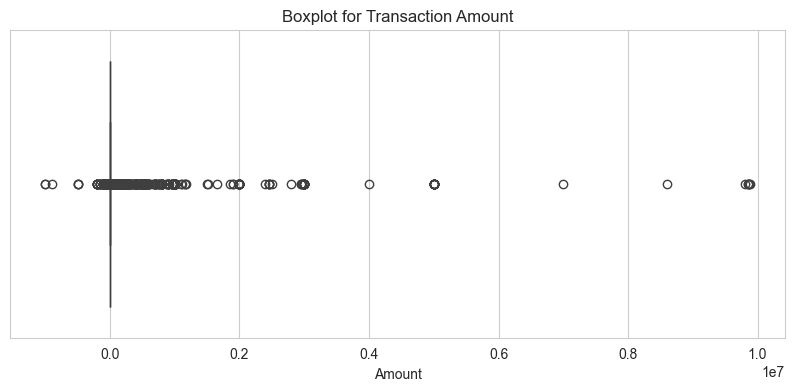

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])

# Outlier detection for Amount using a box plot
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Amount'])
plt.title('Boxplot for Transaction Amount')
plt.show()

## Summary of EDA Findings

Based on the initial exploration of the dataset, here are the top 4 most important insights that will guide our feature engineering and modeling process:

1.  **`TransactionStartTime` Requires Type Conversion:**
    *   **Observation:** The `df.info()` output confirms that the `TransactionStartTime` column is currently an `object` (i.e., a string) data type.
    *   **Implication:** To perform any time-based analysis, especially calculating Recency, Frequency, and Monetary (RFM) metrics, this column is unusable in its current state. It is a critical preprocessing step to convert this to a proper `datetime` format.

2.  **`Amount` Feature is Extremely Skewed with Significant Outliers:**
    *   **Observation:** Both the histogram and the boxplot for the `Amount` column reveal a distribution that is heavily concentrated around zero with a very long tail of positive values. The `df.describe()` output confirms this: the mean (approx. 6,717) is significantly higher than the median (1,000), and the maximum value (9.88 million) is orders of magnitude larger than the 75th percentile (2,800).
    *   **Implication:** This extreme skewness means that the feature contains significant outliers. If used directly, these outliers could negatively impact the performance of many machine learning models (especially linear models and clustering algorithms like K-Means). Feature scaling techniques like **Standardization** (to handle outliers) or a **log transformation** will be essential during feature engineering.

3.  **No Missing Values Simplifies Preprocessing:**
    *   **Observation:** The `df.info()` output shows that all 16 columns have 95,662 non-null entries, which perfectly matches the total number of rows in the DataFrame.
    *   **Implication:** This is a key finding that simplifies our work. We do not need to develop a strategy for handling missing data, such as removing rows or using imputation techniques (e.g., filling with mean/median). Our data processing pipeline will be cleaner as a result.

4.  **Categorical Features are Key Candidates for Prediction:**
    *   **Observation:** The dataset contains numerous categorical columns like `ProductCategory`, `ProviderId`, and `ChannelId` that describe the nature of the transactions.
    *   **Implication:** It's highly likely that customer behavior, and therefore our proxy for risk, will be strongly influenced by the types of products they buy or the channels they use. These features will need to be encoded into a numerical format (e.g., using One-Hot Encoding or Weight of Evidence) to be used in the model. Visualizing their distributions with a `countplot` would be the next logical step to confirm which categories are most frequent.